### Applying TF
This example notebook solves the same problem from the [Stanford CNN site](http://cs231n.github.io/neural-networks-case-study/) but uses Tensor Flow instead of building the backprop process from scratch.

In [90]:
import numpy as np
import scipy as sp
import tensorflow as tf
import matplotlib.pyplot as plt
import random as rnd
import os
%matplotlib inline

In [91]:
curr_dir = os.getcwd()
summaries_loc = os.path.join(curr_dir, 'summaries', 'toy')

In [92]:
# Build the same data set...
N = 300
Ntest = 50
D = 2
K = 3
X = np.zeros((N*K, D)) # row is a single vector (x1, x2)
y = np.zeros(N*K, dtype='uint8')
y_onehot = np.zeros((N*K, K))
Xtest = np.zeros((Ntest*K, D))
ytest = np.zeros(Ntest*K, dtype='uint8')
y_onehot_test = np.zeros((Ntest*K, K))

for i in xrange(K):
    xidx = range(N*i,N*(i+1))
    xt_idx = range(Ntest*i,Ntest*(i+1))
    r = np.linspace(0.0,1,N)
    theta = np.linspace(i*4, (i+1)*4, N) + np.random.randn(N)*0.15
    X[xidx] = np.c_[np.float32(r*np.sin(theta)), np.float32(r*np.cos(theta))]
    y[xidx] = i
    class_as_onehot = np.zeros(K)
    class_as_onehot[i] = 1
    y_onehot[xidx] = class_as_onehot
    r_test = np.linspace(0.0,1,Ntest)
    theta_test = np.linspace(i*4, (i+1)*4, Ntest) + np.random.randn(Ntest)*0.2
    Xtest[xt_idx] = np.c_[r_test*np.sin(theta_test), r_test*np.cos(theta_test)]
    ytest[xt_idx] = i
    class_as_onehot_test = np.zeros(K)
    class_as_onehot_test[i] = 1
    y_onehot_test[xt_idx] = class_as_onehot_test

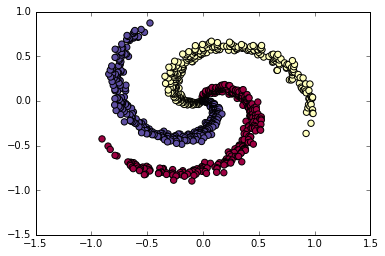

In [93]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)

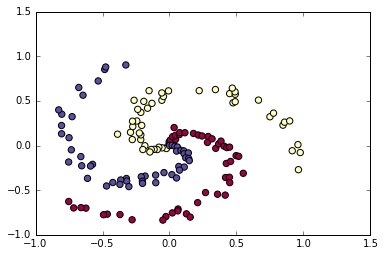

In [94]:
plt.scatter(Xtest[:, 0], Xtest[:, 1], c=ytest, s=40, cmap=plt.cm.Spectral)

In [95]:
# TF placeholder for the input and target data (y_targ)
x = tf.placeholder(tf.float32, [None, 2])
y_targ = tf.placeholder(tf.float32, [None, K])
num_neurons = 100

Time to follow some best practices: encapsulate the construction of a connected nn layer.
This code follows the [TensorBoard recommendations](https://www.tensorflow.org/versions/r0.10/how_tos/summaries_and_tensorboard/index.html) for better debug!

In [96]:
# Borrowed from the website above. Adds names to layers and variables for logging
# and visualization in TensorBoard.
def variable_summaries(var, name):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.scalar_summary('mean/' + name, mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_sum(tf.square(var - mean)))
        tf.scalar_summary('sttdev/' + name, stddev)
        tf.scalar_summary('max/' + name, tf.reduce_max(var))
        tf.scalar_summary('min/' + name, tf.reduce_min(var))
        tf.histogram_summary(name, var)
    
def fully_conn_nn_layer(input_tensor, in_dim, out_dim, layer_name, act_fn=tf.nn.relu):
    with tf.name_scope(layer_name):
        with tf.name_scope('weights'):
            W = tf.Variable(tf.truncated_normal([in_dim, out_dim]))
            variable_summaries(W, layer_name + '/weights')
        with tf.name_scope('biases'):
            b = tf.Variable(tf.random_normal([out_dim]))
            variable_summaries(b, layer_name + '/biases')
        with tf.name_scope('Wx_plus_b'):
            pre_act = tf.matmul(input_tensor, W) + b
            tf.histogram_summary(layer_name + '/pre_acts_hist', pre_act)
        acts = act_fn(pre_act, 'activations')
        tf.histogram_summary(layer_name + '/activations', acts)
        return acts, W, b

In [97]:
# Layer 1 - ReLU activation layer
layer1, W1, b1 = fully_conn_nn_layer(x, 2, num_neurons, 'layer1')

In [98]:
# Layer 2 - Softmax to generate class probabilities
y_output, W2, b2 = fully_conn_nn_layer(layer1, num_neurons, K, 'layer2', act_fn=tf.nn.softmax)

In [99]:
# Loss function construction:
l = 0.001
reg_loss = 0.5 * l * (tf.reduce_sum(W1*W1) + tf.reduce_sum(W2*W2)) 
xentropy = tf.reduce_mean(-tf.reduce_sum( y_targ * tf.log(y_output), reduction_indices=[1] ))
loss = xentropy + reg_loss

In [100]:
with tf.name_scope('train'):
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

In [101]:
init = tf.initialize_all_variables()

In [102]:
sess = tf.Session()

In [103]:
sess.run(init)

In [104]:
def next_batch(xs, ys, batch_size):
    xs_shape = np.shape(xs)
    ys_shape = np.shape(ys)
    idxs = rnd.sample(range(0,xs_shape[0]), batch_size)
    xs_rand = xs[idxs, :]
    ys_rand = ys[idxs,:]
    return xs_rand, ys_rand

In [105]:
with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'):
        correct_pred = tf.equal(tf.argmax(y_output,1), tf.argmax(y_targ,1))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    tf.scalar_summary('accuracy', accuracy)

In [106]:
# Send out the summaries for TensorBoard.
merged_summaries = tf.merge_all_summaries()
train_writer = tf.train.SummaryWriter(summaries_loc + '/train', sess.graph)
test_writer = tf.train.SummaryWriter(summaries_loc + '/test')

In [107]:
for i in range(2000):
    batch_xs, batch_ys = next_batch(X, y_onehot, 50)
    sess.run(train_step, feed_dict={x: batch_xs, y_targ: batch_ys})
    if i % 10 == 0:
        summary, acc = sess.run([merged_summaries, accuracy], feed_dict={x: Xtest, y_targ: y_onehot_test})
        test_writer.add_summary(summary, i)
        print('Accuracy at step %s: %s' % (i, acc))
    else:
        summary, _ = sess.run([merged_summaries, train_step], feed_dict={x: batch_xs, y_targ: batch_ys})
        train_writer.add_summary(summary, i)

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_2' with dtype float
	 [[Node: Placeholder_2 = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]
Caused by op u'Placeholder_2', defined at:
  File "/usr/local/Cellar/python/2.7.11/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/local/Cellar/python/2.7.11/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/site-packages/traitlets/config/application.py", line 592, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 405, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 260, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 212, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 370, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 175, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2902, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 3006, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 3066, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-4d2cc5871b78>", line 2, in <module>
    x = tf.placeholder(tf.float32, [None, 2])
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/ops/array_ops.py", line 895, in placeholder
    name=name)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1238, in _placeholder
    name=name)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/ops/op_def_library.py", line 704, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2260, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1230, in __init__
    self._traceback = _extract_stack()


In [ ]:
print(sess.run(accuracy, feed_dict={x: Xtest, y_targ: y_onehot_test}))